# Exploratory Data Analysis - NYC Taxt Trip Duration


Kaggle Competation Link: https://www.kaggle.com/c/nyc-taxi-trip-duration/

## 1. Problem Statement:

In this competition, the challenge is to build a model that predicts the total ride duration of taxi trips in New York City.

Feel free to provide Suggestions, Feedback and Upvotes :)

## 2. Python Libraries

In [193]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import pandas_profiling

from sklearn import linear_model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno

## 3. Datasets

In [194]:
# #Datasets
!ls input/

sample_submission.csv test.csv              train.csv


In [195]:
# #Train and Test Datasets
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

df_sample_submission = pd.read_csv("input/sample_submission.csv")

### 3.1. Data Dictionary

Dataset: input/train.csv

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

Dataset: input/test.csv

* The train dataset contains 11 columns and the test dataset contains 9 columns. The two additional columns that are present in the train dataset, and not in the test dataset are dropoff_datetime and trip_duration. 

Dataset: input/sample_submission.csv

* id - a unique identifier for each trip
* trip_duration - duration of the trip in seconds

### 3.2. Dataset Overview

#### Training Dataset

In [196]:
print("Total number of samples in train dataset: ", df_train.shape[0])
print("Number of columns in train dataset: ", df_train.shape[1])

('Total number of samples in train dataset: ', 1458644)
('Number of columns in train dataset: ', 11)


In [197]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [198]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [199]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### Test Dataset

In [200]:
print("Total number of samples in test dataset: ", df_test.shape[0])
print("Number of columns in test dataset: ", df_test.shape[1])

('Total number of samples in test dataset: ', 625134)
('Number of columns in test dataset: ', 9)


In [201]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


#### Sample Submission Dataset

In [202]:
df_sample_submission.shape

(625134, 2)

In [203]:
df_sample_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


## 4. Missing Values:

Are there any missing values in the train and test datasets?

In [204]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [205]:
df_test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

_Fortunately, both the train and test datasets are clean & none of the values are missing._

## 5. Open-Questions/Hypothesis:
(In-Progress)

1. Remove outliers based on the haversine_distance, trip duration, latitude and longitude

2. Using the Google Maps API to calculate accurate distances 

3. Post trip_duration outlier detection, try this:
plt.figure(figsize=(10,10))
sns.distplot(df_train["trip_duration"], bins=10, kde=True)
plt.xlabel('trip_duration in seconds')
plt.show()

3.1 Analysis on pickup times

4. Potential Features:
vendor_id
Hour of pickup & day of the week
pickup and drop off lat/long coordinates
Direction in which the taxi was moving based on the pickup-dropoff latlong coordinates
Speed of the taxi

### 5.1. Difference in the columns between the training and test datasets:
The training dataset contains 11 columns and the test dataset contains 9 columns. The two additional columns that are present in the training dataset, and not in the test dataset are dropoff_datetime and trip_duration. By looking at the sample_submission.csv file, we understand that we need to predict the trip_duration.

### 5.2. Are all the id's in the train and test datasets unique? Is there an overlap, in the observations, between the train and test datasets?

In [206]:
print("Number of ids in the train dataset: ", len(df_train["id"]))
print("Number of unique ids in the train dataset: ", len(pd.unique(df_train["id"])), "\n")

print("Number of ids in the test dataset: ", len(df_test["id"]))
print("Number of unique ids in the test dataset: ", len(pd.unique(df_test["id"])), "\n")

print("Number of common ids(if any) between the train and test datasets: ", \
len(set(df_train["id"].values).intersection(set(df_test["id"].values))))

('Number of ids in the train dataset: ', 1458644)
('Number of unique ids in the train dataset: ', 1458644, '\n')
('Number of ids in the test dataset: ', 625134)
('Number of unique ids in the test dataset: ', 625134, '\n')
('Number of common ids(if any) between the train and test datasets: ', 0)


### 5.3. Are all the vendor_id's in the train and test datasets unique? 

* vendor_id takes on only two values in both the train and test datasets i.e. 1 and 2 (Hypothesis - This could represent data from two different taxi companies)

#### This leads to a set of follow-up questions:

* If the hypothesis is right and the values in the vendor_id column actually represent the data from two different taxi companies; are the number of observations in the dataset from each of the companies comparable or is there any imbalance?(Both in the train and test datasets)

* Among the vendor_id's(1 and 2) - what is the distribution in the number of passengers (passenger_count) across the train and test datasets?

In [207]:
print("Number of vendor_ids in the train dataset: ", len(df_train["vendor_id"]))
print("Number of unique vendor_ids in the train dataset: ", len(pd.unique(df_train["vendor_id"])), "\n")

print("Number of vendor_ids in the test dataset: ", len(df_test["vendor_id"]))
print("Number of unique vendor_ids in the test dataset: ", len(pd.unique(df_test["vendor_id"])), "\n")

('Number of vendor_ids in the train dataset: ', 1458644)
('Number of unique vendor_ids in the train dataset: ', 2, '\n')
('Number of vendor_ids in the test dataset: ', 625134)
('Number of unique vendor_ids in the test dataset: ', 2, '\n')


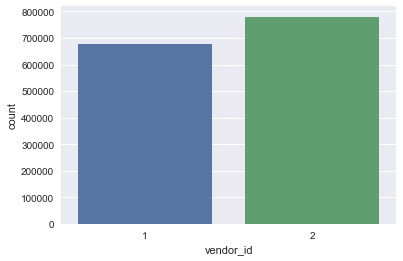

In [208]:
# #The number of observations in the dataset from each of the two companies i.e. 1 and 2, seems to be comparable
# #across the train and test datasets
sns.countplot(x="vendor_id", data=df_train)

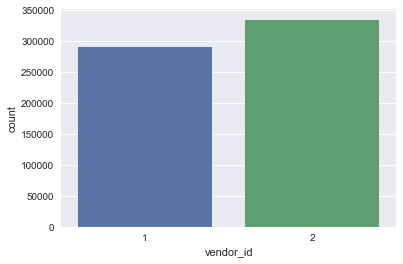

In [209]:
sns.countplot(x="vendor_id", data=df_test)

### 5.4. Distribution of the number of passengers (passenger_count) across the vendor_id variables - 1 and 2, in both the train and test datasets:

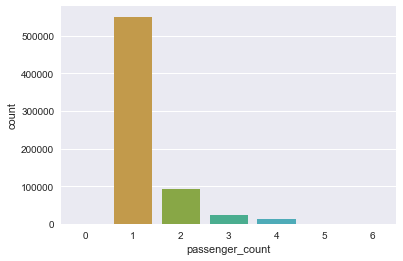

In [210]:
sns.countplot(x="passenger_count", data=df_train[df_train["vendor_id"] == 1])

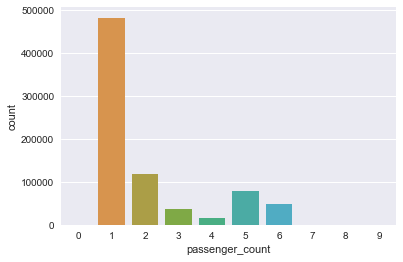

In [211]:
sns.countplot(x="passenger_count", data=df_train[df_train["vendor_id"] == 2])

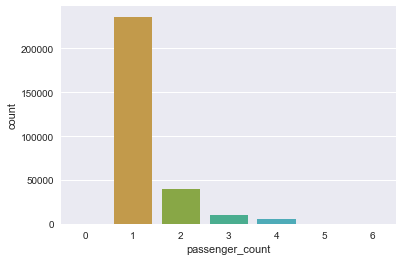

In [212]:
sns.countplot(x="passenger_count", data=df_test[df_test["vendor_id"] == 1])

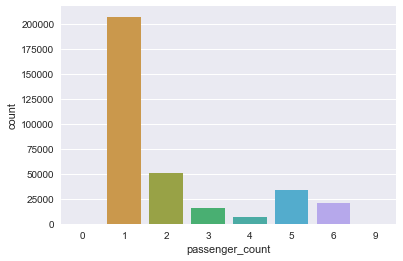

In [213]:
sns.countplot(x="passenger_count", data=df_test[df_test["vendor_id"] == 2])

### 5.5. Distribution of the trip_duration across the train dataset:

In [214]:
# #String to Datetime conversion
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])
df_train["dropoff_datetime"] = pd.to_datetime(df_train["dropoff_datetime"])

df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])

In [215]:
# #trip_duration represents the difference between the dropoff_datetime and the pickup_datetime in the
# #train dataset
df_train["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [216]:
# #The trip_duration would be a lot more intuitive when the datetime representation is used, 
# #rather than the representation with seconds. 
(df_train["dropoff_datetime"] - df_train["pickup_datetime"]).describe()

count                   1458644
mean     0 days 00:15:59.492272
std      0 days 01:27:17.431724
min             0 days 00:00:01
25%             0 days 00:06:37
50%             0 days 00:11:02
75%             0 days 00:17:55
max            40 days 19:31:22
dtype: object

_It is interesting to see that there happens to be a trip that lasted for over 40 days. Let us plot the trip duration in seconds to view any other possbile outliers._

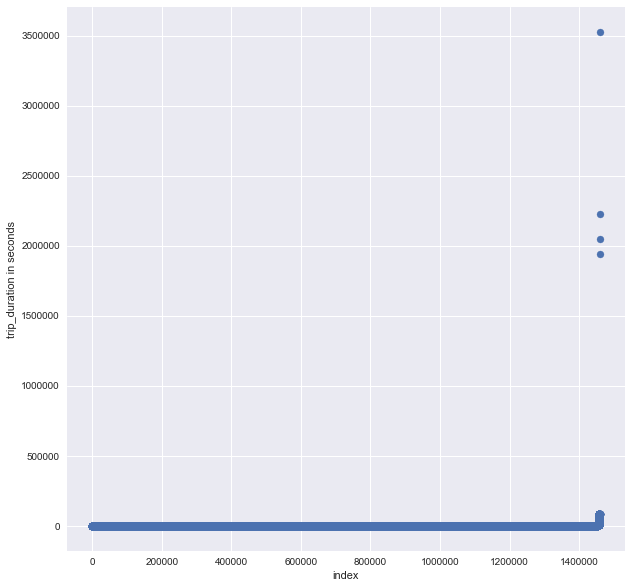

In [217]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

_We see that there are four outliers with trip durations of 20 days or more_

In [218]:
# #Removing the outliers in the dataset
df_train = df_train[df_train["trip_duration"] < 500000]

In [219]:
(df_train["dropoff_datetime"] - df_train["pickup_datetime"]).describe()

count                   1458640
mean     0 days 00:15:52.815251
std      0 days 00:52:51.322283
min             0 days 00:00:01
25%             0 days 00:06:37
50%             0 days 00:11:02
75%             0 days 00:17:55
max             0 days 23:59:52
dtype: object

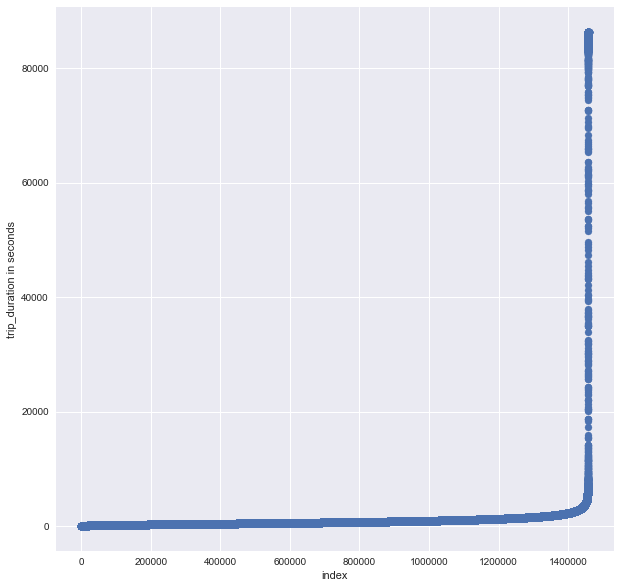

In [220]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

_It is interesting to see that a lot of trips, have a trip duration nearing 23 hours_

### 5.6. Distribution of the store_and_fwd_flag across the train dataset:

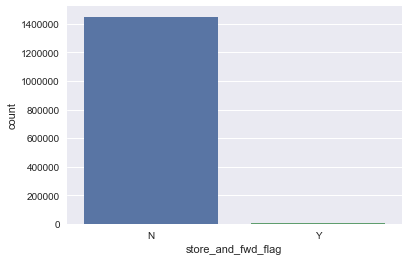

In [221]:
sns.countplot(x="store_and_fwd_flag", data=df_train)

_According to the Data Dictionary the store and fwd flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip. This must therefore indicate that most of the trips(99.448% to be precise) were not stored in the vehicle memory before forwarding._

_**Hypothesis** - In 99.448% of the trips, the vehicles might have been in an area of NYC, where the celluar reception was good; thereby having a connection to the server. In 0.551% of the trips, the celluar reception might have been poor; thereby having to store the trip record in the vehicle memory prior to sending it to the server. Could this affect the dropoff longitude and latitude? Would the dropoff coordinates not have been recorded until celluar reception was availbale again? If so, must we ignore such records while building the model?_

In [222]:
len(df_train[df_train["store_and_fwd_flag"] == "N"])*100.0/(df_train.count()[0])

99.44845883836999

_Among the 0.551% of the trips in the train dataset, where the trip record was stored in the vehicle memory; we observe that all the 0.551% of the cases were only for vendor id = 1._

In [223]:
set(df_train[df_train["store_and_fwd_flag"] == "Y"]["vendor_id"])

{1}

### 5.7. Exploring the distances between the pickup and dropoff lat/log coordinates:

In [224]:
from haversine import haversine

In [225]:
def calculate_haversine_distance(var_row):
    return haversine((var_row["pickup_latitude"], var_row["pickup_longitude"]), 
                     (var_row["dropoff_latitude"], var_row["dropoff_longitude"]), miles = True)

In [226]:
# #Calculating the Haversine Distance
# #The haversine formula determines the great-circle distance between two points on a sphere 
# #given their longitudes and latitudes.
df_train["haversine_distance"] = df_train.apply(lambda row: calculate_haversine_distance(row), axis=1)

In [227]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.931137
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.121890
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.967515
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.923046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.738554


In [228]:
df_train["haversine_distance"].describe()

count    1.458640e+06
mean     2.138039e+00
std      2.669720e+00
min      0.000000e+00
25%      7.654260e-01
50%      1.300971e+00
75%      2.408013e+00
max      7.710647e+02
Name: haversine_distance, dtype: float64

_Plot of the haversine distance vs the trip duration._

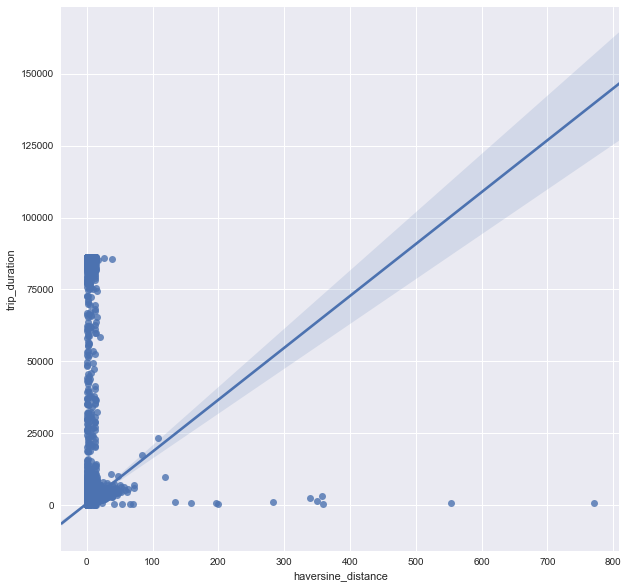

In [242]:
plt.figure(figsize=(10,10))
sns.regplot(x="haversine_distance", y="trip_duration", data=df_train)

_The presence of outliers in the train dataset(long tail in the haversine distance) might have caused the deviation in the regression line. It would be interesting to explore different methods for outlier detection._

In [243]:
df_train[df_train["haversine_distance"] > 100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine_distance,pickup_dayofweek,pickup_weekday_name,pickup_hour,pickup_month
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917,39.803932,-73.796021,40.707726,N,23440,107.515425,0,Monday,12,2
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,771.064665,5,Saturday,18,5
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,195.585348,2,Wednesday,16,2
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,198.916873,5,Saturday,20,4
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,339.177534,3,Thursday,13,4
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,158.054116,3,Thursday,15,6
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,359.676140,0,Monday,18,2
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,349.356641,2,Wednesday,21,2
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,553.774599,2,Wednesday,20,1
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,282.873682,3,Thursday,18,5


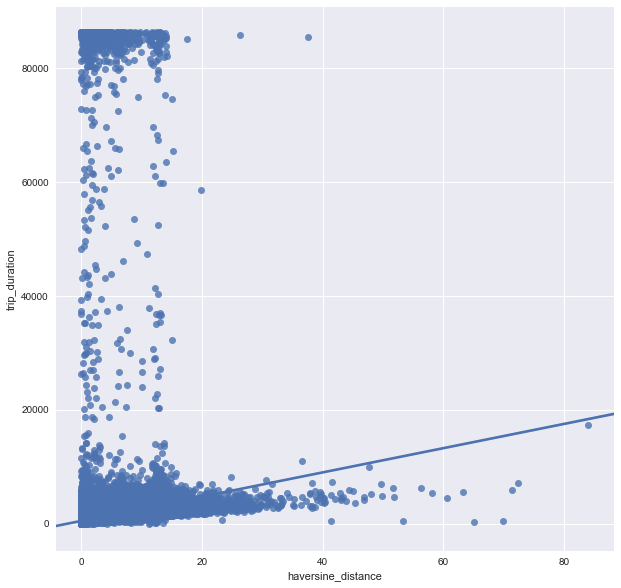

In [244]:
plt.figure(figsize=(10,10))
sns.regplot(x="haversine_distance", y="trip_duration", data=df_train[df_train["haversine_distance"] < 100])

### 5.8. Exploring the number of trips at each timestamp feature in the train dataset:

_Once the train dataset has been cleaned, based on the outliers in column - trip duration(that consisted of a few trips lasting for 20 days or more), we can now explore the timestamps on a hourly-weekly basis for further exploratory analysis._

_The train dataset contains trips that range from 2016-01-01 to 2016-06-30, i.e. 6 months worth of data._

In [232]:
print("Train dataset start date: ", min(df_train["pickup_datetime"]))
print("Train dataset end date: ", max(df_train["pickup_datetime"]))

('Train dataset start date: ', Timestamp('2016-01-01 00:00:17'))
('Train dataset end date: ', Timestamp('2016-06-30 23:59:39'))


In [233]:
# #Conversion to pandas to_datetime has already been performed in section 5.5
# #df_train["pickup_datetime"] = pd.to_datetime(df_train['pickup_datetime'])


df_train["pickup_dayofweek"] = df_train.pickup_datetime.dt.dayofweek
df_train["pickup_weekday_name"] = df_train.pickup_datetime.dt.weekday_name
df_train["pickup_hour"] = df_train.pickup_datetime.dt.hour
df_train["pickup_month"] = df_train.pickup_datetime.dt.month

In [234]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine_distance,pickup_dayofweek,pickup_weekday_name,pickup_hour,pickup_month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.931137,0,Monday,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.121890,6,Sunday,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.967515,1,Tuesday,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.923046,2,Wednesday,19,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.738554,5,Saturday,13,3


_Distribution of trips across - months in the six month rage, day of the week and hour in a day._

_We can observe that there are more trips on Friday's and Saturday's, than on any other weekday, and this make sense (TGIF :)); On a 24 hour clock, the number of trips is the highest between 17:00 hrs - 22:00 hrs and reduces post 01:00 hrs; On a six month time range, the number of trips are almost evenly distributed, with none of the months having a surprising spike in the dataset. _

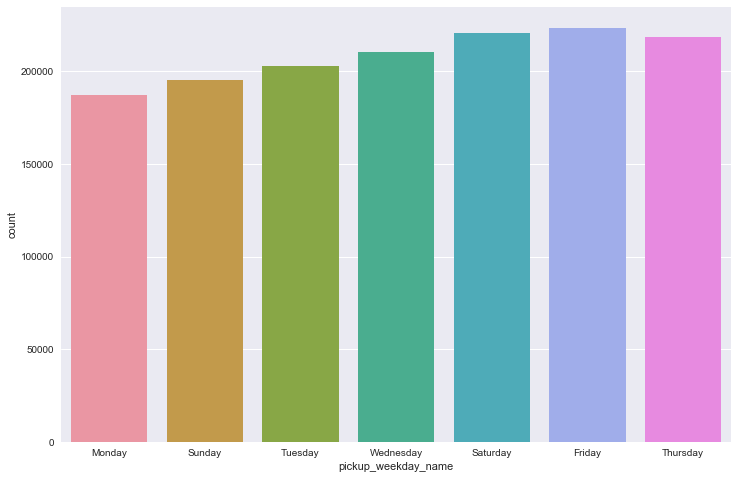

In [235]:
plt.figure(figsize=(12,8))
sns.countplot(x="pickup_weekday_name", data=df_train)
plt.show()

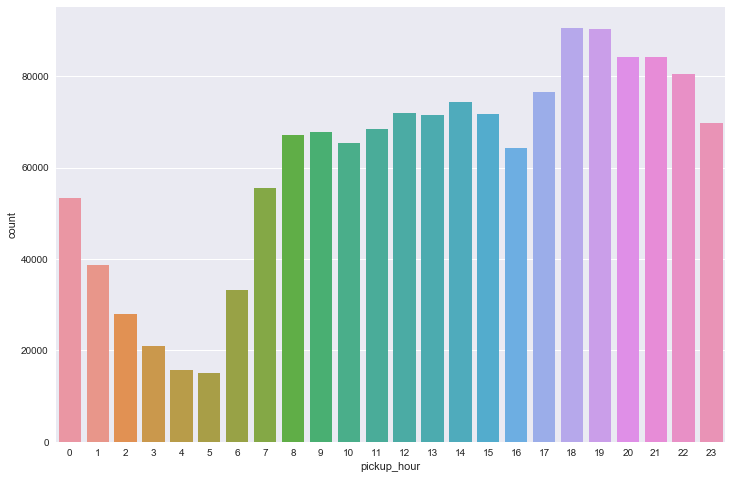

In [236]:
plt.figure(figsize=(12,8))
sns.countplot(x="pickup_hour", data=df_train)
plt.show()

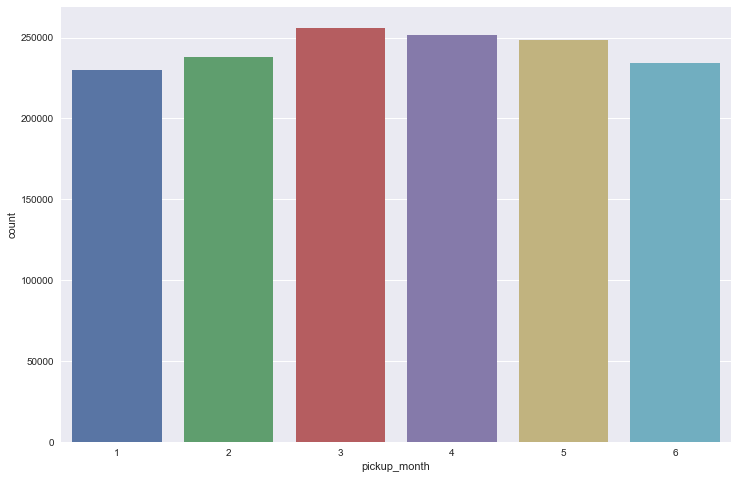

In [237]:
plt.figure(figsize=(12,8))
sns.countplot(x="pickup_month", data=df_train)
plt.show()

_It would now be interesting to visualize the behaviour of the trip duration variable, based on the timestamp features._

### 5.9. Exploring the behaviour of trip_duration based on the number of trips for each timestamp feature in the train dataset:

_In order to visualize the trip duration behaviour, it would be important to aggregate the trip duration at each of the timnestamp feature levels. Since there could be outliers in the trip duration variable(and outlier detection has not yet been performed for this variable) median would be a more representative measure, rather than the mean._

In [238]:
df_train.trip_duration.describe()

count    1.458640e+06
mean     9.528153e+02
std      3.171322e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      8.639200e+04
Name: trip_duration, dtype: float64

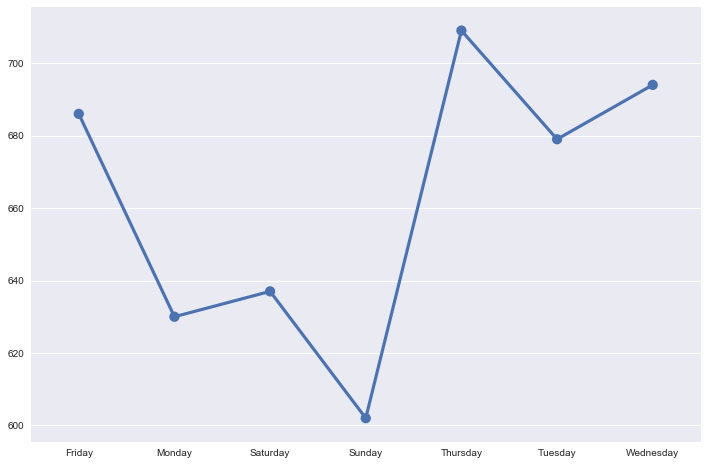

In [239]:
df_train_agg = df_train.groupby('pickup_weekday_name')['trip_duration'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_weekday_name.values, df_train_agg.trip_duration.values)
plt.show()

In [250]:
df_train.groupby('pickup_weekday_name')['trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_weekday_name,,,,,,,,
Friday,223533.0,990.224200,3274.974477,1.0,410.0,686.0,1112.0,86390.0
Monday,187418.0,897.947839,2769.429213,1.0,380.0,630.0,1027.0,86392.0
Saturday,220866.0,922.814317,3515.782988,1.0,385.0,637.0,1012.0,86377.0
Sunday,195366.0,901.639395,3456.093920,1.0,364.0,602.0,978.0,86369.0
Thursday,218574.0,1006.528654,3100.383654,1.0,420.0,709.0,1155.0,86387.0
Tuesday,202747.0,962.918401,3058.192485,1.0,407.0,679.0,1102.0,86391.0
Wednesday,210136.0,975.450494,2903.805145,1.0,416.0,694.0,1133.0,86366.0


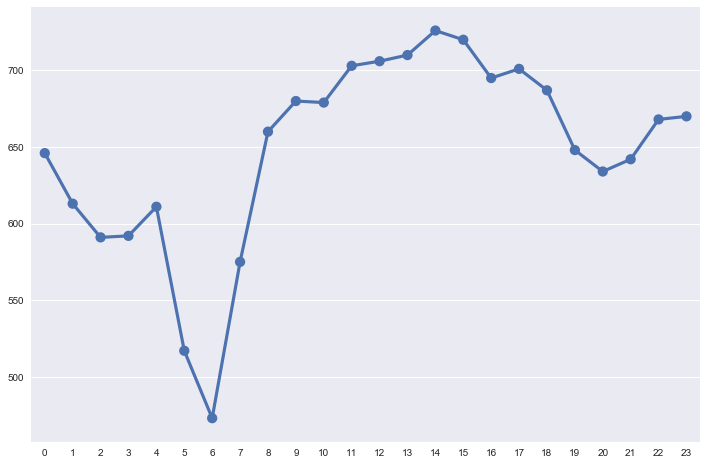

In [240]:
df_train_agg = df_train.groupby('pickup_hour')['trip_duration'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_hour.values, df_train_agg.trip_duration.values)
plt.show()

In [251]:
df_train.groupby('pickup_hour')['trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_hour,,,,,,,,
0,53247.0,900.245873,3223.040076,1.0,389.00,646.0,1039.00,86390.0
1,38571.0,903.087112,3733.570656,2.0,371.00,613.0,977.00,86355.0
2,27972.0,890.076934,4003.839902,1.0,354.00,591.0,942.00,86369.0
3,20895.0,890.070878,3961.003485,2.0,350.00,592.0,954.50,86325.0
4,15792.0,921.976444,3976.500021,1.0,339.75,611.0,1027.00,86377.0
5,15002.0,822.298960,2952.808616,1.0,287.00,517.0,999.75,86277.0
6,33247.0,730.457034,2221.319764,2.0,290.00,473.0,802.00,86346.0
7,55600.0,831.758345,2522.785416,2.0,355.00,575.0,917.00,86361.0
8,67053.0,924.559199,2812.643178,2.0,394.00,660.0,1069.00,86362.0


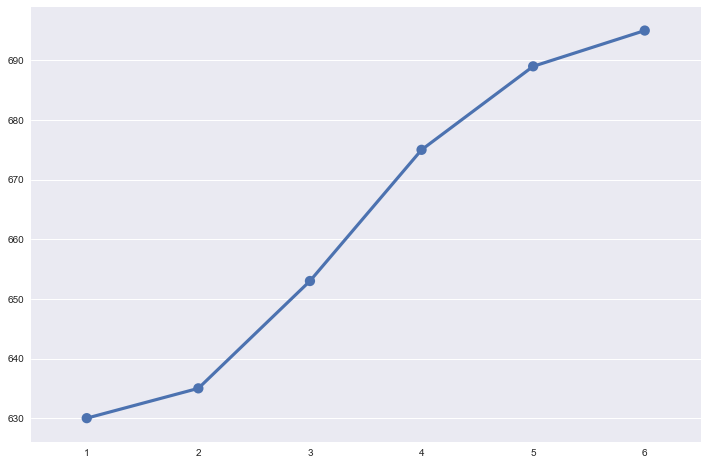

In [241]:
df_train_agg = df_train.groupby('pickup_month')['trip_duration'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_month.values, df_train_agg.trip_duration.values)
plt.show()

In [245]:
df_train.groupby('pickup_month')['trip_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
pickup_month,,,,,,,,
1,229705.0,904.239176,3123.083824,1.0,383.0,630.0,1013.0,86369.0
2,238298.0,897.439496,3057.137598,1.0,384.0,635.0,1022.0,86392.0
3,256189.0,937.365363,3213.214383,1.0,393.0,653.0,1052.0,86366.0
4,251645.0,962.891462,3158.773635,1.0,403.0,675.0,1097.0,86364.0
5,248487.0,999.450555,3186.775737,1.0,408.0,689.0,1133.0,86391.0
6,234316.0,1013.367226,3279.534457,1.0,414.0,695.0,1141.0,86387.0


* Observation at a week-level:

_Trip durations are the most on Thursday's, Wednesday's and Friday's & the least on Sunday's._


* Observation at an hour-level:

_Trip durations are the most between 11:00 hrs and 16:00 hrs & the least between 04:00 hrs and 07:00 hrs._

* Observation at a month-level:

_There seems to be a linear increase in the median trip duration from the month of January to the month of June, although the increase is fairly minimal._

** In Progress  **